# Fixtures

In general, a fixture is simply a a known state or context in which a test is performed.  With such a fixture in place, a test will—or should, if other components behave as intended—perform in a determinable way so that assertions will hold.  As a side-note, sometimes "statistical determinism" is sufficient for a test, not necessarily *precisely* identical behavior.

Common resources or contexts we work with include database connections, temporary files or other filesystem configuration, web connections, file handles, sockets, or other external items that a test relies upon.

##  Adding a server

One common need for fixtures arises when code being tested needs to interact with some kind of computer server or service.  A connection to that service is generally provided within a fixture.  Within `unittest` such a connection is generally configured within a `.setUp()` method, and perhaps cleaned up within a `.tearDown()`.

In `pytest` we use fixture functions that may have session, module, class, or function scope.  Moreover, dependency relations among them are resolved to assure they are created in needed order.

### The number server

To enhance the Fractal project, we add a small service that will provide infinite integer sequences and accept commands to affect their generation.  This service is stateful in the sense that if it has provided N numbers from a given sequence, the next request will start by providing the N+1th element.

Let us look in a few slides at the behavior of this service. The service operates at a finite speed, populating a buffer as needed (we cannot generate all infinitely many numbers in the sequence at once).  In concept, the service might generate numeric sequences that are difficult or impossible to generate within individual consumers.

In [1]:
import os, sys
from time import sleep
sys.path.append('Fractal')
from server.number_server import make_server

In [2]:
server = make_server(queued=50)
# No elements buffered because sequence not specified
server.n_ready   

0

In [3]:
server.command('START PRIMES')
sleep(0.1)  # Takes a small while to fill buffer
server.n_ready

50

In [5]:
print(server.get(10))
print(server.get(15))
print(server.n_ready)  # Reduced buffer
sleep(0.01)
server.n_ready  # Should be refilled

[101, 103, 107, 109, 113, 127, 131, 137, 139, 149]
[151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229]
25


50

In [6]:
# Clear current sequence
server.command('FLUSH')
sleep(0.01)
server.n_ready

0

In [7]:
# Start a new sequence and get a few elements
server.command('START FIBONACCI')
server.get(15)

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610]

### Canvases utilizing the service

While most number sequences will not produce fractals per se, we have added few functions to create visualizations of the number sequences produced by the number server.

In [8]:
from fractal.sequences import scatter_step, scatter
from fractal.visualize import visualize

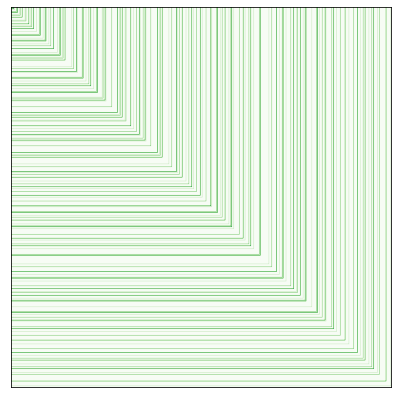

In [9]:
seq1 = make_server().command('START PRIMES')
seq2 = make_server().command('START PRIMES')
canvas = scatter_step(seq1, seq2, ncolor=4)
visualize(canvas, cmap="Greens")

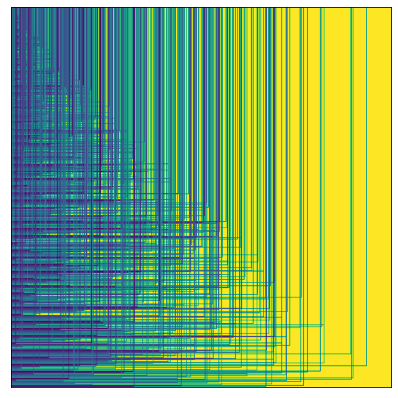

In [10]:
seq3 = make_server().command('START NATURAL')
seq4 = make_server().command('START STOCHASTIC_INCREASING')
canvas = scatter_step(seq3, seq4)
visualize(canvas, stretch_palette=True)

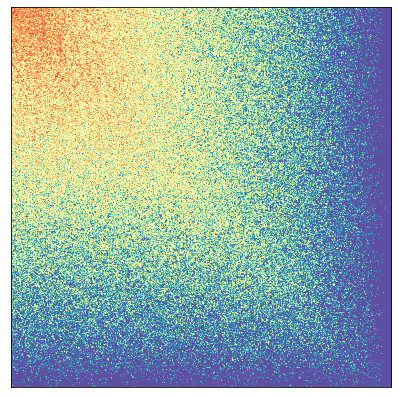

In [11]:
seq5 = make_server().command('START STOCHASTIC_SLOW')
seq6 = make_server().command('START STOCHASTIC_SLOW')
canvas = scatter(seq5, seq6)
visualize(canvas, stretch_palette=True, cmap="Spectral")

Those number servers are running in threads and utilize queues.  Let us make sure everything is shut down properly.

In [12]:
for seq in [server, seq1, seq2, seq3, seq4, seq5, seq6]:
    seq.command('STOP')

## Tests with fixtures

We can create some tests based on fixtures for number servers we have constructed.  It is first important to understand the ordering and lifespan of created fixtures.  The `pytest` documentation has a detailed example.


Walking through this can help us understand these lifespans better.  This will be important for the stateful servers that may be at different positions in their infinite streams depending on which tests have interacted with them, in which order.  If not otherwise specified, a fixture will have function scope.

In [13]:
!cd Fractal; pytest test/test_fixture.py::test_order

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /home/dmertz/git/INE/unittest/05-Mocks-Fixtures/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_fixture.py .                                                   [100%]

============================== 1 passed in 0.03s ===============================


```python
@pytest.fixture
def f1(f3): order.append("f1")

@pytest.fixture
def f3(): order.append("f3")

@pytest.fixture(autouse=True)
def a1(): order.append("a1")
```
```python
@pytest.fixture(scope="session")
def s1(): order.append("s1")

@pytest.fixture(scope="module")
def m1(): order.append("m1")

def test_order(f1, m1, s1):
    assert order == ["s1", "m1", "a1", "f3", "f1"]
```    

The `pytest` example only used the fixtures for their side effect of appending to a list.  But we can also use the fixtures as values themselves by returning those values, e.g.:

```python
@pytest.fixture
def val():
    return 3

def test_val(val):
    assert val == 3
```

In [14]:
!cd Fractal; pytest test/test_fixture.py::test_value

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /home/dmertz/git/INE/unittest/05-Mocks-Fixtures/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_fixture.py .                                                   [100%]

============================== 1 passed in 0.03s ===============================


Better than simply returning a value is to **yield** it.  Then whatever comes before the yield is setup, and whatever comes after is teardown.  This is a similar pattern to that provided in writing context managers with `@contextlib.contextmanager`.

We create tests in `test_numbers.py` that illustrate many of these concepts.

```python
import pytest
import numpy as np
from server.number_server import make_server
from fractal.sequences import scatter
```
```python
@pytest.fixture(scope="session")
def pixels():
    return 200
```
```python
@pytest.fixture(scope="module")
def zero_seq():
    zero_seq = make_server()
    zero_seq.command('START ZEROES')
    yield zero_seq
    zero_seq.command('FLUSH')
    zero_seq.command('STOP')
```

We can peform a test utilizing the `zero_seq` fixture.  The `pixels` one is equivalent to the one shown previously.

```python
def test_zeroes(zero_seq):
    # Server gives all zeroes and fetches more than buffer
    assert zero_seq.n_ready == 50
    assert all(n == 0 for n in zero_seq.get(1000))
```

In [15]:
!cd Fractal; pytest test/test_numbers.py::test_zeroes

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /home/dmertz/git/INE/unittest/05-Mocks-Fixtures/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_numbers.py .                                                   [100%]

============================== 1 passed in 0.21s ===============================


For other fixtures, module scope will not work.  For example, the integer sequence `STOCHASTIC_SLOW` asymptotically approaches infinity, but slowly and not monotonically.  Different portions of the infinite sequence are therefore different.  To utilize two from their start, we need two fixtures.

```python
@pytest.fixture(scope="function")
def slow_seq_A():
    slow_seq = make_server()
    slow_seq.command('START STOCHASTIC_SLOW')
    yield slow_seq
    slow_seq.command('FLUSH')
    slow_seq.command('STOP')

# slow_seq_B() defined in same manner as slow_seq_A()
```

The server fixture includes the teardown necessary to end the thread and cleanup the queues it is holding onto.  But in concept, the setup and teardown could even be on other remote machines or utilize clusters.

```python
def test_density(slow_seq_A, slow_seq_B, pixels):
    canvas = scatter(slow_seq_A, slow_seq_B, pixels=pixels)
    ratio = np.count_nonzero(canvas)/pixels**2
    assert 0.25 < ratio < 0.40
```

We also use the trivial fixture `pixels` only defines a constant here, albeit one that would be shared among all files during a test run.  However, the fixture function could do anything else, of arbitrary complexity, as needed.

Being stochastic/random, the density of modified pixels on the canvas varies between runs.  Four sigmas gets us roughly 25% to 40% density. Other sequences produce dramatically different densities, either much lower or much higher.  Likewise, many coding bugs would result in falling outside the expected ratio.

In [16]:
!cd Fractal; pytest test/test_numbers.py::test_density

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /home/dmertz/git/INE/unittest/05-Mocks-Fixtures/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_numbers.py .                                                   [100%]

============================== 1 passed in 0.74s ===============================


## Fixture factories

We have taken a look at fixtures that produce values, and ones that include cleanup.  However, in the `test_density()` test we inelegantly wrote two fixtures that had exactly the same code and only differed in name.

Much better would be to create a **factory** that can produce as many fixtures as we would like to use.  Each one will be initialized within a test and cleaned up within the fixture.

```python
@pytest.fixture
def make_slow_seq():
    seqs = []
    # Inner function to return one server object
    def _slow_seq():
        slow_seq = make_server()
        slow_seq.command('START STOCHASTIC_SLOW')
        seqs.append(slow_seq)
        return slow_seq
```
```python
    # yield the inner function
    yield _slow_seq
    
    # Cleanup all of the manufactured fixtures
    for seq in seqs:
        seq.command('STOP')
```

The test only needs to be adjusted slightly:

```python
def test_density2(make_slow_seq, pixels):
    canvas = scatter(make_slow_seq(), 
                     make_slow_seq(),
                     pixels=pixels
    ratio = np.count_nonzero(canvas)/pixels**2
    assert 0.25 < ratio < 0.40
```

In [17]:
!cd Fractal; pytest test/test_numbers.py::test_density2

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /home/dmertz/git/INE/unittest/05-Mocks-Fixtures/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_numbers.py .                                                   [100%]

============================== 1 passed in 0.73s ===============================


## Parameterized fixtures

Much as we sometimes parameterize tests, we can also parameterize fixtures.  Either one is available individually, and in fact they can be combined.  Of course, if both sets of parameterization are present, the number of tests grow as the product of the number in each.  The same is true if multiple parameterized fixtures are used.

It is uncommon to want both approaches to parameterization, but such is available.  For example the toy tests in the next slides.

```python
@pytest.fixture(scope="function", params=[2, 3, 4, 5])
def fixnum(request):
    return request.param
```
```python
@pytest.mark.parametrize("num", [param(7), param(8)])
def test_param_product(fixnum, num):
    assert True
```

In [18]:
!cd Fractal; pytest -v test/test_numbers.py::test_param_product

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1 -- /home/dmertz/miniconda3/envs/INE/bin/python
cachedir: .pytest_cache
rootdir: /home/dmertz/git/INE/unittest/05-Mocks-Fixtures/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 8 items                                                              

test/test_numbers.py::test_param_product[2-7] PASSED                     [ 12%]
test/test_numbers.py::test_param_product[2-8] PASSED                     [ 25%]
test/test_numbers.py::test_param_product[3-7] PASSED                     [ 37%]
test/test_numbers.py::test_param_product[3-8] PASSED                     [ 50%]
test/test_numbers.py::test_param_product[4-7] PASSED                     [ 62%]
test/test_numbers.py::test_param_product[4-8] PASSED                     [ 75%]
test/test_numbers.py::test_param_product[5-7] PASSED                     [ 87%]
test/test_numbers.py::test_param_prod

In a more useful case, we might want to check that every sequence produced by the number server has some sensible expected properties.  We still want to use fixtures to assure cleanup.

```python
@pytest.fixture(scope="module", 
                params=['PRIMES', 'FIBONACCI', 'NATURAL', 
                        'STOCHASTIC_INCREASING', 
                        'STOCHASTIC_SLOW'])
def seq_kind(request):
    seq = make_server()
    seq.command(f'START {request.param}')
    yield seq
    seq.command('FLUSH')
    seq.command('STOP')
```

Notice that we chose module scope for the fixtures.  They are available for every test performed within the same test file.  This means that *potentially* some other test will have consumed some of the numbers before the test shown utilizes them.  However, this test does not depend upon where in the infinite sequence we sample.

```python
def test_ascending_ints(seq_kind):
    seq = seq_kind.get(1000)
    # Only integers in produced list
    assert all(isinstance(n, int) for n in seq)
    # Loosely ascending order
    assert mean(seq[:100]) < mean(seq[450:550]) < mean(seq[-100:])
```

In [19]:
!cd Fractal; pytest -v test/test_numbers.py::test_ascending_ints

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1 -- /home/dmertz/miniconda3/envs/INE/bin/python
cachedir: .pytest_cache
rootdir: /home/dmertz/git/INE/unittest/05-Mocks-Fixtures/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 5 items                                                              

test/test_numbers.py::test_ascending_ints[PRIMES] PASSED                 [ 20%]
test/test_numbers.py::test_ascending_ints[FIBONACCI] PASSED              [ 40%]
test/test_numbers.py::test_ascending_ints[NATURAL] PASSED                [ 60%]
test/test_numbers.py::test_ascending_ints[STOCHASTIC_INCREASING] PASSED  [ 80%]
test/test_numbers.py::test_ascending_ints[STOCHASTIC_SLOW] PASSED        [100%]

============================== 5 passed in 0.39s ===============================


## Summary

In this lesson we have seen quite a bit of the power of `pytest` fixtures.  We can flexibly provide setup and configuration of needed contexts and resources.

The final lesson of this course will address the concept of *mocking* which in some ways builds on fixtures.